In [2]:
import psycopg2
import yaml
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud

%matplotlib.inline 

In [3]:
from elasticsearch import Elasticsearch 

In [5]:
es = Elasticsearch([{'host':'localhost','port':1111}])
es

<Elasticsearch([{'host': 'localhost', 'port': 1111}])>

First we need to set up the analyzer that we want for the text: 

+ tokenizer: standard -> whitespace
+ filter: "lowercase","asciifolding","stop","stemmer"

In [128]:
# first we need to close the index
es.indices.close(index="bill_text")

{'acknowledged': True,
 'shards_acknowledged': True,
 'indices': {'bill_text': {'closed': True}}}

In [129]:
analyzer_settings={"analysis": {
      "analyzer": {
        "aclu_analyzer": { 
          "type": "custom",
          "tokenizer": "standard",
          "filter": [
            "lowercase",
            "asciifolding",
            "stop",
            "classic"
          ]
        }
      }
}}

In [130]:
es.indices.put_settings(index="bill_text", body=analyzer_settings)

{'acknowledged': True}

In [131]:
es.indices.open(index="bill_text")

{'acknowledged': True, 'shards_acknowledged': True}

In [ ]:
'''
mapping_settings = {
    'properties': {
        "doc": {
            'type': 'text',
            'analyzer': 'aclu_analyzer'
        }
    }
}
'''

In [127]:
#es.indices.put_mapping(index="bill_text", body=mapping_settings)

In [135]:
es.indices.get_settings(index="bill_text")

{'bill_text': {'settings': {'index': {'number_of_shards': '1',
    'provided_name': 'bill_text',
    'creation_date': '1593660720736',
    'analysis': {'analyzer': {'aclu_analyzer': {'filter': ['lowercase',
        'asciifolding',
        'stop',
        'classic'],
       'type': 'custom',
       'tokenizer': 'standard'}}},
    'number_of_replicas': '1',
    'uuid': 'YfhgyuJbR-SH6a7IfonHCA',
    'version': {'created': '7070199'}}}}}

In [136]:
search_query = {'query': {'match': {'doc': 'reproductive rights'}}}

In [137]:
res = es.search(index="bill_text", body=search_query)

In [138]:
num_docs = len(res['hits']['hits'])

In [139]:
def analyze_bill_text(bill):
    analyze_text = {
    "analyzer": "aclu_analyzer",
    "text": bill
    }
    
    return es.indices.analyze(index="bill_text", body=analyze_text)
    

In [141]:
text_docs = []
clean_tokens = []

for i in range(num_docs):
    bill = res['hits']['hits'][i]['_source']['doc']
    text_docs.append(bill)
    
    tokens = analyze_bill_text(bill)
    for element in tokens['tokens']:
        clean_tokens.append(element['token'])

In [142]:
len(clean_tokens)

12950

In [143]:
set_tokens=set(clean_tokens)

In [144]:
len(set_tokens)

2122

In [145]:
text = " ".join(clean_tokens) 

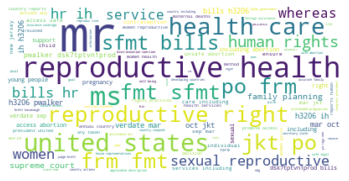

In [146]:
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()